In [1]:
#!/bin/bash
!curl -L -o libri-noise-dataset.zip https://www.kaggle.com/api/v1/datasets/download/earth16/libri-speech-noise-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 6178M  100 6178M    0     0   179M      0  0:00:34  0:00:34 --:--:--  167M


In [2]:
!unzip -q libri-noise-dataset.zip

In [3]:
!rm -rf BWAVN.7z epoc-27-results.xltx LibriNoise_Train_Test_NPY ModelArchitecture.txt model.h5.png noisesB.7z NoiseTest.pptx NoiseTest_SNR.pptx results.7z

In [4]:
!7z x train.7z -onoisy > /dev/null

In [5]:
!7z x y_train.7z -odenoised > /dev/null

In [6]:
!7z x test.7z -onoisy > /dev/null
!7z x y_test.7z -odenoised > /dev/null

In [1]:
import librosa
import glob
import matplotlib.pyplot as plt
from IPython.display import Audio, IFrame, display
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
!ls noisy/train/103-1240-0005.wav

noisy/train/103-1240-0005.wav


In [3]:
!ls denoised/

y_test	y_train


In [4]:
train_noisy_files = sorted(glob.glob('noisy/train/*.wav'))
train_clear_files = sorted(glob.glob('denoised/y_train/*.wav'))
assert len(train_clear_files) == len(train_noisy_files)

In [5]:
train_noisy_files[0], train_clear_files[0]

('noisy/train/103-1240-0005.wav', 'denoised/y_train/103-1240-0005.wav')

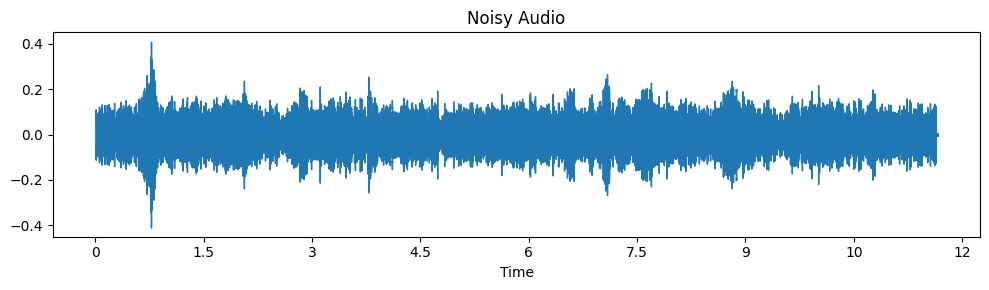

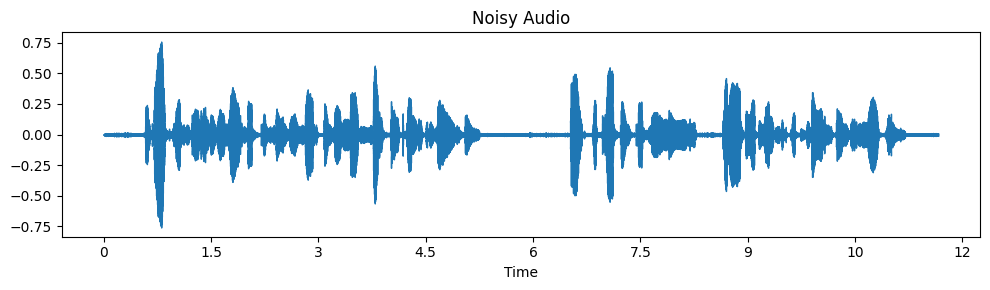

In [6]:
sr = 16000

idx = 1000

x, sr = librosa.load(train_noisy_files[idx], mono=True, sr=sr, offset=0, duration=16)
plt.figure(figsize=(10, 3))
librosa.display.waveshow(x, sr=sr, axis='time')
plt.title("Noisy Audio")
plt.tight_layout()
plt.show()
display(Audio(x,rate=sr))

y, sr = librosa.load(train_clear_files[idx], mono=True, sr=sr, offset=0, duration=16)
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr, axis='time')
plt.title("Noisy Audio")
plt.tight_layout()
plt.show()
display(Audio(y,rate=sr))

In [7]:
import glob
import librosa
import torch
from torch.utils.data import Dataset
import random
import numpy as np
import random

class MyDataset(Dataset):
    def __init__(self, noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', ind=None, need_crop=False, cnt_seconds=16, need_all=False, single_file_path=None):
        if (single_file_path is not None):
            self.noisy_files = [single_file_path]
            self.clear_files = [single_file_path]
        else:
            self.noisy_files = np.array(sorted(glob.glob(noisy_folder + '*.wav')))
            self.clear_files = np.array(sorted(glob.glob(denoised_folder + '*.wav')))
        # print(len(self.clear_files))

        assert len(self.noisy_files) == len(self.clear_files)
        for f, s in zip(self.noisy_files, self.clear_files):
            assert f.split('/')[-1] == s.split('/')[-1]

        if ind is not None:
            self.noisy_files = self.noisy_files[ind]
            self.clear_files = self.clear_files[ind]
        self.cnt_seconds = cnt_seconds
        self.sr = 16000
        self.need_crop = need_crop
        self.need_all = need_all
            
    def __len__(self):
        return len(self.noisy_files)

    def __getitem__(self, idx):
        need_size = self.cnt_seconds * self.sr
        
        noisy_file = self.noisy_files[idx]
        clear_file = self.clear_files[idx]

        noisy_arr, _ = librosa.load(noisy_file, mono=True, sr=self.sr, offset=0)
        clear_arr, _ = librosa.load(clear_file, mono=True, sr=self.sr, offset=0)

        noisy_arr = torch.tensor(noisy_arr, dtype=torch.float)
        clear_arr = torch.tensor(clear_arr, dtype=torch.float)

        

        if self.need_all:
            noisy_segments = []
            clear_segments = []

            num_segments = max(len(noisy_arr) // need_size, 1)
            for i in range(num_segments):
                start = i * need_size
                noisy_segments.append(noisy_arr[start:start + need_size])
                clear_segments.append(clear_arr[start:start + need_size])

            noisy_segments = [seg if seg.shape[0] == need_size else torch.cat((seg, torch.zeros(need_size - seg.shape[0]))) for seg in noisy_segments]
            clear_segments = [seg if seg.shape[0] == need_size else torch.cat((seg, torch.zeros(need_size - seg.shape[0]))) for seg in clear_segments]

            
            return (torch.stack(noisy_segments).unsqueeze(1), torch.stack(clear_segments).unsqueeze(1))

        if not self.need_crop:
            noisy_arr = torch.cat((noisy_arr[:need_size], torch.zeros(need_size - noisy_arr.shape[0])))
            clear_arr = torch.cat((clear_arr[:need_size], torch.zeros(need_size - clear_arr.shape[0])))
        else:
            l = random.randint(0, max(1, noisy_arr.shape[0] - need_size))
            r = min(l + need_size, noisy_arr.shape[0])
            noisy_arr = noisy_arr[l:r]
            clear_arr = clear_arr[l:r]
            noisy_arr = torch.cat((noisy_arr[:need_size], torch.zeros(need_size - noisy_arr.shape[0])))
            clear_arr = torch.cat((clear_arr[:need_size], torch.zeros(need_size - clear_arr.shape[0])))

        assert noisy_arr.shape == clear_arr.shape

        noisy_arr = noisy_arr.unsqueeze(0)
        clear_arr = clear_arr.unsqueeze(0)

        return (noisy_arr, clear_arr)


In [8]:

n_total = 7000
cnt_valid = 400
all_indices = list(range(n_total))

random.seed(42)
random.shuffle(all_indices)
valid_indices = np.array(all_indices[:cnt_valid])
train_indices = np.array(all_indices[cnt_valid:])

train_dataset = MyDataset(noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', need_crop=True, cnt_seconds=4, need_all=False, ind=train_indices)
valid_dataset = MyDataset(noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', need_crop=True, cnt_seconds=4, need_all=True, ind=valid_indices)
test_dataset = MyDataset(noisy_folder='noisy/test/',  denoised_folder='denoised/y_test/', need_crop=True, cnt_seconds=4, need_all=True)

In [9]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(6600, 400, 105)

In [10]:
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [11]:
train_dataset[0][0].shape

torch.Size([1, 64000])

In [12]:
class UModel(nn.Module):
    def make_ds_block(self, idx):
        in_channels = (1 if idx == 1 else self.F_c*(idx-1))
        out_channels = self.F_c * idx
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=self.f_d, padding=self.f_d//2),
            nn.BatchNorm1d(out_channels),
            nn.MaxPool1d(kernel_size=2),
            nn.LeakyReLU(0.2),
        )

    def make_us_block(self, idx):
        in_channels = self.F_c * idx * 2
        
        out_channels = self.F_c * idx
        
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=self.f_u, padding=self.f_u//2),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def __init__(self, L, F_c, f_d, f_u, k):
        super().__init__()
        self.L = L
        self.F_c = F_c
        self.f_d = f_d
        self.f_u = f_u
        self.k = k
        
        self.ds_blocks = []
        for i in range(1, L + 1):
            self.ds_blocks.append(self.make_ds_block(i))

        self.back_bone = nn.Conv1d(self.F_c*L, self.F_c*(L+1), kernel_size=self.f_d, padding=self.f_d//2)


        self.us_blocks = [None] * L
        for i in range(1, L + 1, 1):
             self.us_blocks[i - 1] = self.make_us_block(i)

        self.conv1d_blocks = [None] * L
        for i in range(1, L + 1, 1):
            in_channels = self.F_c*(i+1)
            out_channels = self.F_c*i
            self.conv1d_blocks[i - 1] = nn.Conv1d(in_channels, out_channels, kernel_size=1)
            
        self.ds_blocks = nn.ModuleList(self.ds_blocks)
        self.us_blocks = nn.ModuleList(self.us_blocks)
        self.conv1d_blocks = nn.ModuleList(self.conv1d_blocks)

        self.Final_block = nn.Sequential(
            nn.Conv1d(self.F_c + 1, self.k, kernel_size=1, padding=0),
            nn.BatchNorm1d(self.k),
            nn.Tanh(),
        )

    def forward(self, X):
        
        ds_tensors = []
        ds_tensors.append(X)
        for i in range(1, self.L + 1):
            X = self.ds_blocks[i - 1](X)
            ds_tensors.append(X)

        X = self.back_bone(X)
        for i in range(self.L, 0, -1):
            if (i < self.L):
                cur_X = F.interpolate(X, scale_factor=2, mode='linear') # B x self.F_c*(idx+1) x n_f
            else:
                cur_X = X
            # print(cur_X.shape, ds_tensors[i - 1].shape)
            # print(i, cur_X.shape)
            cur_X = self.conv1d_blocks[i - 1](cur_X)
            skip = ds_tensors[i]
            # print(i, cur_X.shape, skip.shape)

            len_cur = cur_X.size(-1)
            len_skip = skip.size(-1)
            if len_cur < len_skip:
                cur_X = F.pad(cur_X, (0, len_skip - len_cur))
            elif len_cur > len_skip:
                cur_X = cur_X[..., :len_skip]
        
                
            new_X = torch.concat((cur_X, skip), dim=1)
            # print(new_X.shape)
            X = self.us_blocks[i - 1](new_X)

        X = F.interpolate(X, scale_factor=2, mode='linear')
        # print(X.shape, self.conv1d_blocks[0])
        new_X = torch.concat((X, ds_tensors[0]), dim=1)
        X = self.Final_block(new_X)
        return X

# model = UModel(L=10, F_c=24, f_d=15, f_u=5, k=10)

In [15]:
!pip install asteroid

In [16]:
!pip install pesq

In [17]:
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio
from pesq import pesq

2025-07-14 13:35:40.404429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752500140.427436   41257 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752500140.434471   41257 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
from torchmetrics.audio import PerceptualEvaluationSpeechQuality

In [19]:
def calculate_batch_SI_SDR(preds_batch, y_batch, SI_SDR_metric):
    sum_metric = 0
    for cur_pred, cur_y in zip(preds_batch, y_batch):
        try:
            cur = SI_SDR_metric(cur_pred, cur_y)
            sum_metric += cur
        except:
            continue
    return sum_metric / len(preds_batch)

def calculate_batch_PESQ(preds_batch, y_batch, fs=16000, mode='wb'):
    total, count = 0.0, 0
    for cur_pred, cur_y in zip(preds_batch, y_batch):
        ref = cur_y.squeeze(0).detach().cpu().numpy()
        deg = cur_pred.squeeze(0).detach().cpu().numpy()

        try:
            score = pesq(fs, ref=ref, deg=deg, mode=mode)
            total += score
            count += 1
        except:
            continue

    return total / count if count > 0 else 0.0

In [20]:
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio

def train(model, criterion, train_dataloader, valid_dataset, optimizer, epochs, device, metrics):
    best_sdr = -1e6
    best_loss = 1e6

    SI_SDR_metric = ScaleInvariantSignalDistortionRatio(
        zero_mean=True, 
    ).to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0        

        cnt_steps_train = len(train_dataloader)
        for batch_x, batch_y in tqdm(train_dataloader):

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            with torch.no_grad():
                train_loss += loss.item()


        train_loss /= cnt_steps_train
        print(f'Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f}')

        metrics['train_loss'].append(train_loss)
        
        model.eval()
        valid_loss = 0
        valid_sdr = 0
        # valid_pesq = 0
        with torch.no_grad():
            for batch_x, batch_y in tqdm(valid_dataset):
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                # print(batch_x.shape, batch_y.shape)
                
                preds = model(batch_x)
                loss = criterion(preds, batch_y)
                valid_loss += loss.item()
                
                valid_sdr += SI_SDR_metric(preds, batch_y)
                
                # valid_pesq += calculate_batch_PESQ(preds, batch_y)
                
        valid_loss /= len(valid_dataset)
        valid_sdr /= len(valid_dataset)
        # valid_pesq /= len(valid_dataset)
        

        print(f'Epoch {epoch}/{epochs} | Valid Loss: {valid_loss:.6f} | Valid SI-SDR: {valid_sdr:.4f}')
        
        metrics['valid_loss'].append(valid_loss)
        metrics['valid_si_sdr'].append(valid_sdr)
        # metrics['valid_pesq'].append(valid_pesq)

        if valid_sdr > best_sdr:
            best_sdr = valid_sdr
            sdr_model = model
        if valid_loss < best_loss:
            best_loss = valid_loss
            loss_model = model
            
    return sdr_model, loss_model

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = UModel(L=12, F_c=24, f_d=15, f_u=5, k=1).to(device)
model = UModel(L=10, F_c=32, f_d=15, f_u=5, k=1).to(device)

model = nn.DataParallel(model, device_ids=['cuda:0', 'cuda:1'])
# criterion = nn.MSELoss()

metrics = {
    'train_loss': [],
    'train_si_sdr': [],
    'train_pesq': [],
    'valid_loss': [],
    'valid_si_sdr': [],
    'valid_pesq': []
}


In [23]:
from asteroid.losses import SingleSrcPMSQE

In [24]:
def si_sdr_loss(pred, ref, eps=1e-8):
    # pred/ref shape: [B, 1, T]
    ref_energy = torch.sum(ref**2, dim=-1, keepdim=True) + eps
    proj = torch.sum(pred * ref, dim=-1, keepdim=True) * ref / ref_energy
    
    noise = pred - proj

    num = torch.sum(proj**2, dim=-1)
    den = torch.sum(noise**2, dim=-1)
    ratio = num / (den + eps)
    ratio = torch.clamp(ratio, min=eps)
    sisd = 10 * torch.log10(ratio)
    return -sisd.mean()


class SI_SDR_PESQ_Loss(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
        self.pmsqe = SingleSrcPMSQE(sample_rate=16000).to(device)
        self.si_sdr_loss = si_sdr_loss
        
        self.n_fft = 512
        self.win_length = 512
        self.hop_length = 128
        self.window = torch.hann_window(self.win_length)

    def forward(self, preds, target):
        sdr_loss = self.si_sdr_loss(preds, target)

        preds1 = preds.squeeze(1) 
        target1 = target.squeeze(1)

        window = self.window.to(preds1.device)

        def mag_stft(x):
            stft = torch.stft(x, n_fft=self.n_fft, hop_length=self.hop_length,
                              win_length=self.win_length, window=window,
                              return_complex=True)
            return torch.abs(stft) 

        preds_mag = mag_stft(preds1)
        target_mag = mag_stft(target1)

        pmsqe_loss = self.pmsqe(preds_mag, target_mag).mean()
        return sdr_loss + self.alpha * pmsqe_loss


criterion = SI_SDR_PESQ_Loss(0.7)

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
best_sdr, best_loss = train(model, criterion, train_dataloader, valid_dataset, optimizer, 10, device, metrics)

100%|██████████| 104/104 [02:29<00:00,  1.44s/it]


Epoch 1/15 | Train Loss: 2.446735


100%|██████████| 400/400 [00:22<00:00, 17.44it/s]


Epoch 1/15 | Valid Loss: 0.826217 | Valid SI-SDR: 0.7890


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 2/15 | Train Loss: -0.456379


100%|██████████| 400/400 [00:21<00:00, 18.75it/s]


Epoch 2/15 | Valid Loss: -0.973825 | Valid SI-SDR: 2.4827


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 3/15 | Train Loss: -1.854320


100%|██████████| 400/400 [00:22<00:00, 18.16it/s]


Epoch 3/15 | Valid Loss: -2.452517 | Valid SI-SDR: 3.9644


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 4/15 | Train Loss: -2.932479


100%|██████████| 400/400 [00:22<00:00, 18.01it/s]


Epoch 4/15 | Valid Loss: 5.920816 | Valid SI-SDR: -3.4394


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 5/15 | Train Loss: -2.881157


100%|██████████| 400/400 [00:21<00:00, 18.68it/s]


Epoch 5/15 | Valid Loss: 1.380992 | Valid SI-SDR: 0.2218


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 6/15 | Train Loss: -3.315237


100%|██████████| 400/400 [00:22<00:00, 18.15it/s]


Epoch 6/15 | Valid Loss: -3.597129 | Valid SI-SDR: 5.0137


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 7/15 | Train Loss: -4.155014


100%|██████████| 400/400 [00:21<00:00, 18.26it/s]


Epoch 7/15 | Valid Loss: -1.386990 | Valid SI-SDR: 2.8869


100%|██████████| 104/104 [02:26<00:00,  1.40s/it]


Epoch 8/15 | Train Loss: -4.424071


100%|██████████| 400/400 [00:21<00:00, 18.43it/s]


Epoch 8/15 | Valid Loss: -5.226906 | Valid SI-SDR: 6.5638


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 9/15 | Train Loss: -4.861102


100%|██████████| 400/400 [00:21<00:00, 18.50it/s]


Epoch 9/15 | Valid Loss: -4.141119 | Valid SI-SDR: 5.5551


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 10/15 | Train Loss: -5.056996


100%|██████████| 400/400 [00:21<00:00, 18.44it/s]


Epoch 10/15 | Valid Loss: -4.500760 | Valid SI-SDR: 5.9221


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 11/15 | Train Loss: -5.150893


100%|██████████| 400/400 [00:21<00:00, 19.00it/s]


Epoch 11/15 | Valid Loss: -4.891039 | Valid SI-SDR: 6.2338


100%|██████████| 104/104 [02:26<00:00,  1.40s/it]


Epoch 12/15 | Train Loss: -5.244183


100%|██████████| 400/400 [00:21<00:00, 18.24it/s]


Epoch 12/15 | Valid Loss: -5.645499 | Valid SI-SDR: 6.9798


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 13/15 | Train Loss: -5.470045


100%|██████████| 400/400 [00:21<00:00, 18.19it/s]


Epoch 13/15 | Valid Loss: -5.792656 | Valid SI-SDR: 7.0729


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 14/15 | Train Loss: -5.992044


100%|██████████| 400/400 [00:21<00:00, 18.86it/s]


Epoch 14/15 | Valid Loss: -5.889443 | Valid SI-SDR: 7.1998


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 15/15 | Train Loss: -6.266252


100%|██████████| 400/400 [00:21<00:00, 18.78it/s]

Epoch 15/15 | Valid Loss: -6.646684 | Valid SI-SDR: 7.9024


In [28]:
import copy
tmp_model = copy.deepcopy(model)

In [29]:
best_sdr, best_loss = train(model, criterion, train_dataloader, valid_dataset, optimizer, 5, device, metrics)

100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 1/5 | Train Loss: -6.431498


100%|██████████| 400/400 [00:21<00:00, 18.55it/s]


Epoch 1/5 | Valid Loss: -6.662818 | Valid SI-SDR: 7.9119


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 2/5 | Train Loss: -6.583828


100%|██████████| 400/400 [00:21<00:00, 18.28it/s]


Epoch 2/5 | Valid Loss: -6.897321 | Valid SI-SDR: 8.1664


100%|██████████| 104/104 [02:25<00:00,  1.39s/it]


Epoch 3/5 | Train Loss: -6.678363


100%|██████████| 400/400 [00:21<00:00, 18.60it/s]


Epoch 3/5 | Valid Loss: -6.923942 | Valid SI-SDR: 8.1273


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 4/5 | Train Loss: -6.804311


100%|██████████| 400/400 [00:21<00:00, 18.91it/s]


Epoch 4/5 | Valid Loss: -6.952079 | Valid SI-SDR: 8.1479


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 5/5 | Train Loss: -6.979505


100%|██████████| 400/400 [00:21<00:00, 18.42it/s]

Epoch 5/5 | Valid Loss: -7.431608 | Valid SI-SDR: 8.6163


In [ ]:
model = best_loss

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
best_sdr, best_loss = train(model, criterion, train_dataloader, valid_dataset, optimizer, 15, device, metrics)

100%|██████████| 104/104 [02:28<00:00,  1.43s/it]


Epoch 1/15 | Train Loss: -7.064406


100%|██████████| 400/400 [00:21<00:00, 18.53it/s]


Epoch 1/15 | Valid Loss: -7.423805 | Valid SI-SDR: 8.6181


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 2/15 | Train Loss: -7.256901


100%|██████████| 400/400 [00:21<00:00, 18.57it/s]


Epoch 2/15 | Valid Loss: -7.425416 | Valid SI-SDR: 8.5915


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 3/15 | Train Loss: -7.302069


100%|██████████| 400/400 [00:20<00:00, 19.09it/s]


Epoch 3/15 | Valid Loss: -7.615057 | Valid SI-SDR: 8.7792


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 4/15 | Train Loss: -7.467231


100%|██████████| 400/400 [00:21<00:00, 18.44it/s]


Epoch 4/15 | Valid Loss: -7.839628 | Valid SI-SDR: 8.9884


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 5/15 | Train Loss: -7.604239


100%|██████████| 400/400 [00:21<00:00, 18.93it/s]


Epoch 5/15 | Valid Loss: -7.794797 | Valid SI-SDR: 8.9213


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 6/15 | Train Loss: -7.652082


100%|██████████| 400/400 [00:21<00:00, 18.84it/s]


Epoch 6/15 | Valid Loss: -7.967007 | Valid SI-SDR: 9.1469


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 7/15 | Train Loss: -7.746737


100%|██████████| 400/400 [00:21<00:00, 18.52it/s]


Epoch 7/15 | Valid Loss: -8.116175 | Valid SI-SDR: 9.2286


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 8/15 | Train Loss: -7.747574


100%|██████████| 400/400 [00:22<00:00, 18.15it/s]


Epoch 8/15 | Valid Loss: -8.145671 | Valid SI-SDR: 9.2453


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 9/15 | Train Loss: -7.840616


100%|██████████| 400/400 [00:21<00:00, 18.82it/s]


Epoch 9/15 | Valid Loss: -7.940614 | Valid SI-SDR: 9.0957


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 10/15 | Train Loss: -7.884799


100%|██████████| 400/400 [00:21<00:00, 18.63it/s]


Epoch 10/15 | Valid Loss: -7.707237 | Valid SI-SDR: 8.9377


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 11/15 | Train Loss: -7.874542


100%|██████████| 400/400 [00:21<00:00, 18.28it/s]


Epoch 11/15 | Valid Loss: -8.192853 | Valid SI-SDR: 9.3113


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 12/15 | Train Loss: -7.999892


100%|██████████| 400/400 [00:21<00:00, 18.36it/s]


Epoch 12/15 | Valid Loss: -8.283488 | Valid SI-SDR: 9.3667


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 13/15 | Train Loss: -8.094149


100%|██████████| 400/400 [00:21<00:00, 18.55it/s]


Epoch 13/15 | Valid Loss: -8.426925 | Valid SI-SDR: 9.5337


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 14/15 | Train Loss: -8.167037


100%|██████████| 400/400 [00:21<00:00, 18.49it/s]


Epoch 14/15 | Valid Loss: -8.366932 | Valid SI-SDR: 9.5023


100%|██████████| 104/104 [02:26<00:00,  1.40s/it]


Epoch 15/15 | Train Loss: -8.130842


100%|██████████| 400/400 [00:20<00:00, 19.07it/s]

Epoch 15/15 | Valid Loss: -8.409536 | Valid SI-SDR: 9.5432


In [31]:
model = best_loss

In [36]:
tmp_model = copy.deepcopy(model)

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

In [ ]:
best_sdr, best_loss = train(model, criterion, train_dataloader, valid_dataset, optimizer, 10, device, metrics)

In [ ]:
model = best_loss

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(12, 10))

    
    plt.subplot(2, 1, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, metrics['valid_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()


    
    plt.subplot(2, 1, 2)
    plt.plot(epochs, metrics['valid_si_sdr'], label='Validation SI-SDR', marker='o')
    plt.title('Training and Validation SDR')
    plt.xlabel('Epochs')
    plt.ylabel('SI-SDR')
    plt.legend()
    plt.grid()



    plt.tight_layout()
    plt.show()


In [40]:
# metrics['train_si_sdr'] = [cur.item() for cur in metrics['train_si_sdr']]
metrics['valid_si_sdr'] = [cur.item() for cur in metrics['valid_si_sdr']]

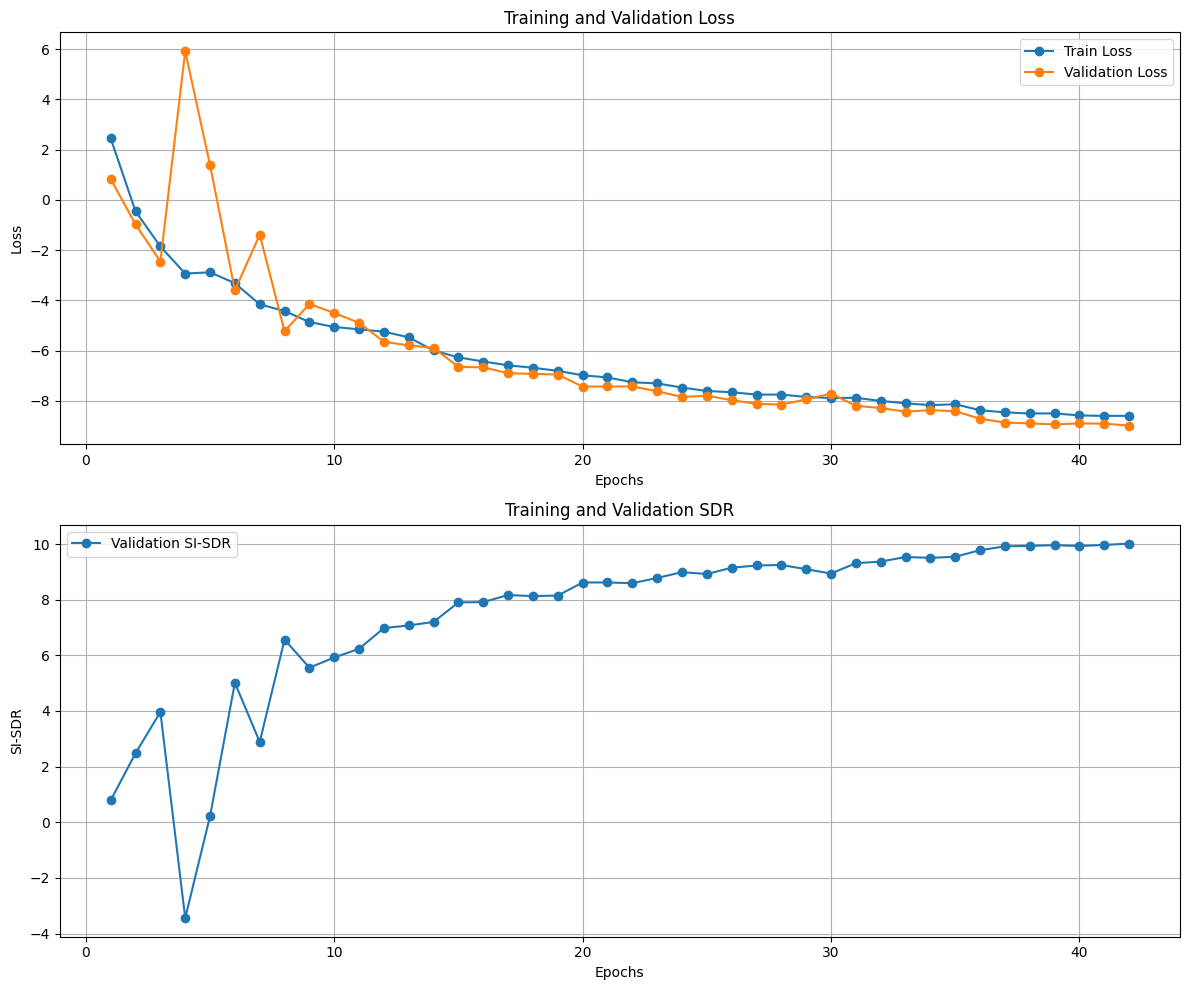

In [41]:
plot_metrics(metrics)

In [ ]:
model = best_loss

In [27]:
def evaluate_test(model, test_dataset, device, criterion):
    model.eval()
    SI_SDR_metric = ScaleInvariantSignalDistortionRatio(
        zero_mean=True,  
    ).to(device)
    loss = 0
    si_sdr = 0
    pesq = 0
    with torch.no_grad():
        for batch_x, batch_y in tqdm(test_dataset):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            preds = model(batch_x)

            loss += criterion(preds, batch_y)
            si_sdr += SI_SDR_metric(preds, batch_y)
            pesq += calculate_batch_PESQ(preds, batch_y)
    loss /= len(test_dataset)
    si_sdr /= len(test_dataset)
    pesq /= len(test_dataset)
    print(f'Test Loss: {loss}, Test SI-SDR: {si_sdr}, Test PESQ: {pesq}')

In [28]:
def denoise_file(path, model, device):
    sr = 16000
    noise_arr,_ = librosa.load(path, mono=True, sr=sr, offset=0, duration=16)
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(noise_arr, sr=sr, axis='time')
    plt.title("Noisy Audio")
    plt.tight_layout()
    plt.show()
    display(Audio(noise_arr,rate=sr))

    with torch.no_grad():
        cur_dataset = MyDataset(need_crop=True, cnt_seconds=2, need_all=True, single_file_path=path)
        
        clear_audio = model(cur_dataset[0][0]).detach().cpu().numpy()
        clear_audio = clear_audio.reshape(-1)
    # print(clear_audio.shape)
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(clear_audio, sr=sr, axis='time')
    plt.title("Clear Audio")
    plt.tight_layout()
    plt.show()
    display(Audio(clear_audio,rate=sr))

In [29]:
evaluate_test(model, test_dataset, device, criterion)

100%|██████████| 105/105 [01:05<00:00,  1.59it/s]

Test Loss: -8.5006742477417, Test SI-SDR: 9.49311637878418, Test PESQ: 1.5889746858014002


In [30]:
torch.save(model.module.state_dict(), 'model_si-sdr_pesq_2.pt')

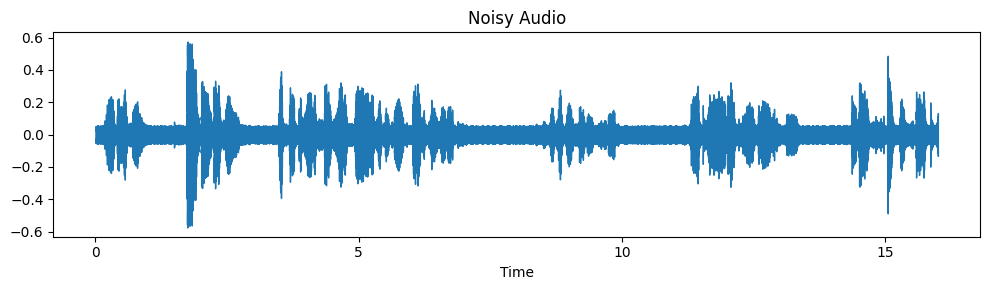

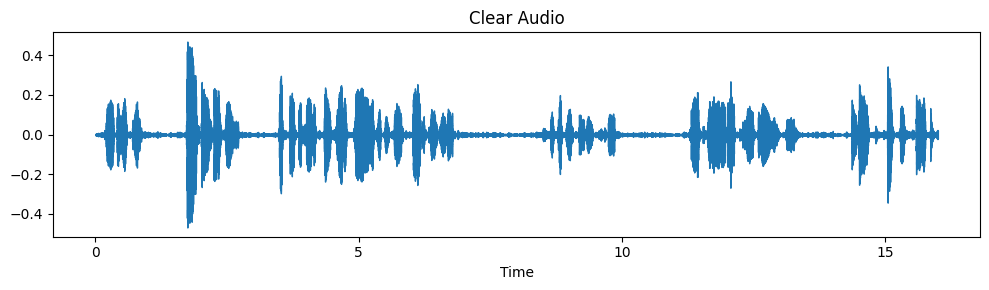

In [31]:
denoise_file('noisy/test/1034-121119-0049.wav', model, device)

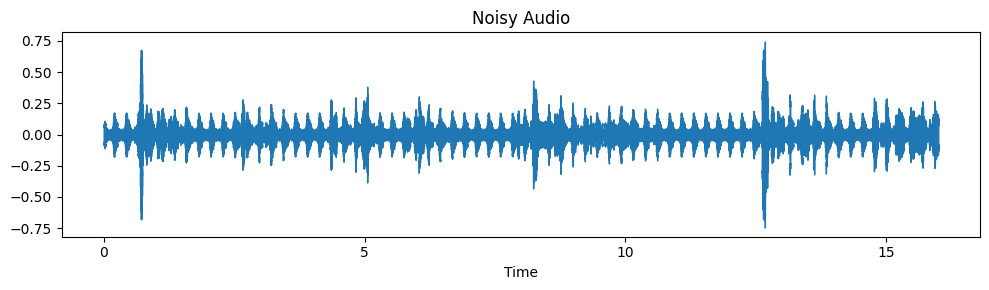

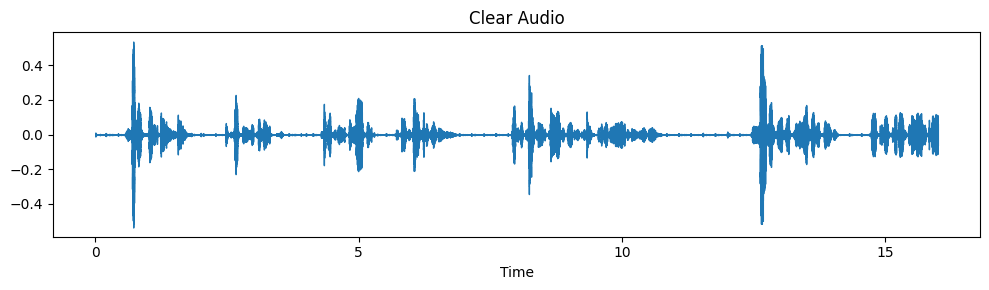

In [32]:
denoise_file('noisy/test/1040-133433-0080.wav', model, device)

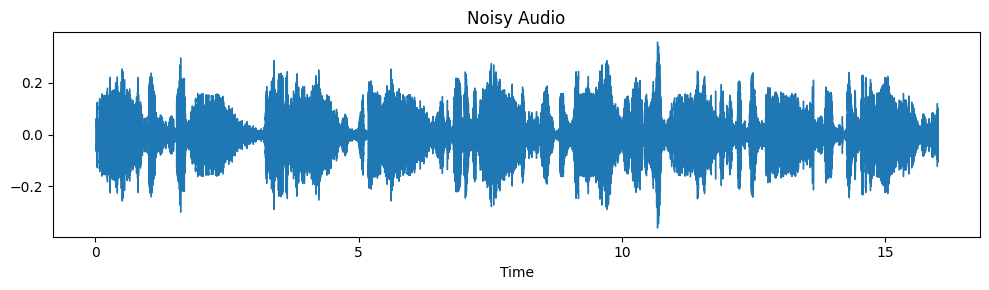

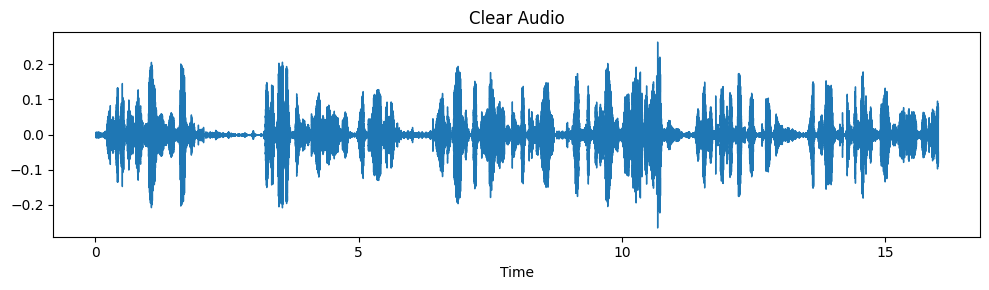

In [33]:
denoise_file('noisy/test/1081-125237-0053.wav', model, device)

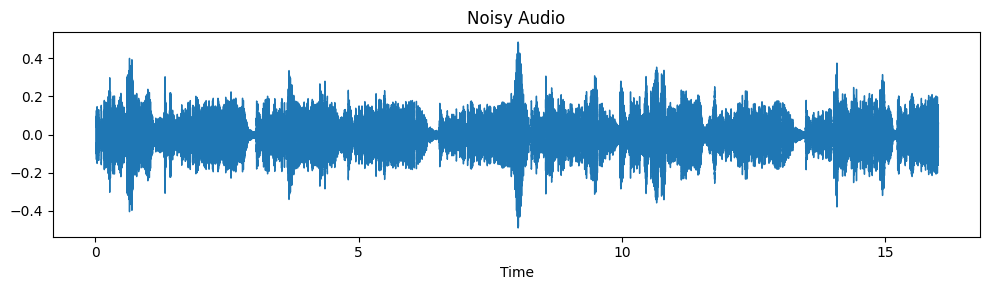

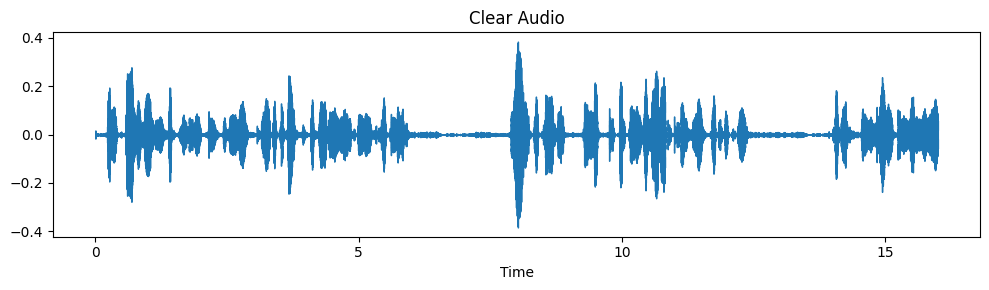

In [34]:
denoise_file('noisy/test/226-131532-0003.wav', model, device)

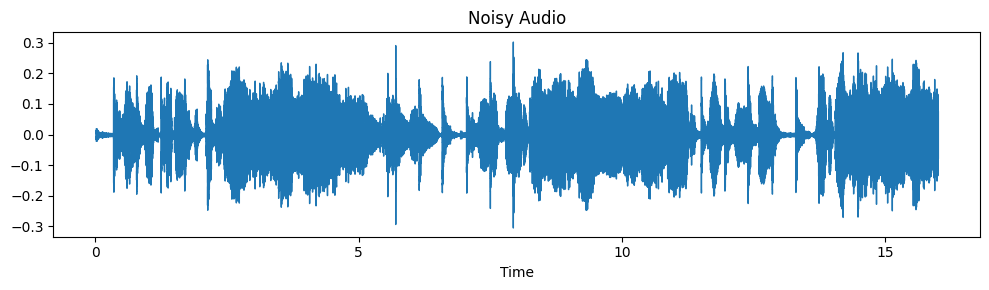

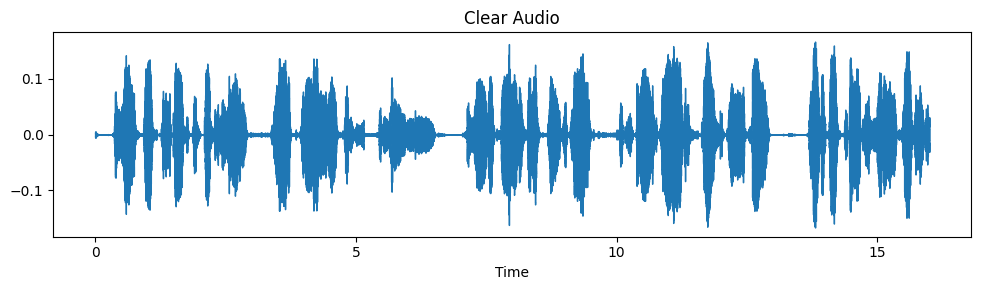

In [35]:
denoise_file('noisy/test/6848-252323-0032.wav', model, device)

In [37]:
!rm -rf denoised libri-noise-dataset.zip noisy samples.7z test.7z train.7z y_test.7z y_train.7z

In [38]:
!ls

model_si-sdr_pesq_2.pt	model_si-sdr_pesq.pt
